# 02 Training ASL Alphabet Classifier on Preprocessed Dataset

### Imports

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import xgboost as xgb
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load the data

In [23]:
data_dict = pickle.load(open('data.pkl', 'rb'))

data = np.asarray(data_dict['data'])
labels = np.asarray(data_dict['labels']).ravel()
print(f'Data shape: {data.shape}')
print(f'Labels shape: {labels.shape}')

Data shape: (5045, 42)
Labels shape: (5045,)


### Random Forest Classifier

In [24]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, shuffle=True, stratify=labels, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

f = open('random_forest_baseline.pkl', 'wb')
pickle.dump({'model': model}, f)
f.close()

Accuracy: 0.9900891972249752
Precision: 0.9906968570279262
Recall: 0.9900891972249752
F1 Score: 0.9901776535707586


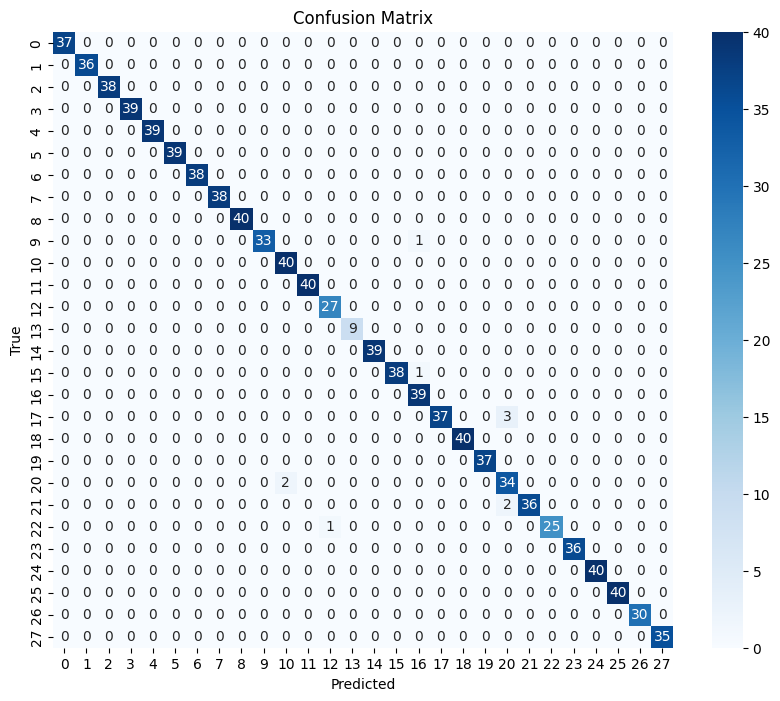

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### XGBoost Classifier

In [26]:
# Create and train the XGBoost model
model = xgb.XGBClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

f = open('xgboost_baseline.pkl', 'wb')
pickle.dump({'model': model}, f)
f.close()

Accuracy: 0.9801783944499505
Precision: 0.9810537283295616
Recall: 0.9801783944499505
F1 Score: 0.9801816089830756


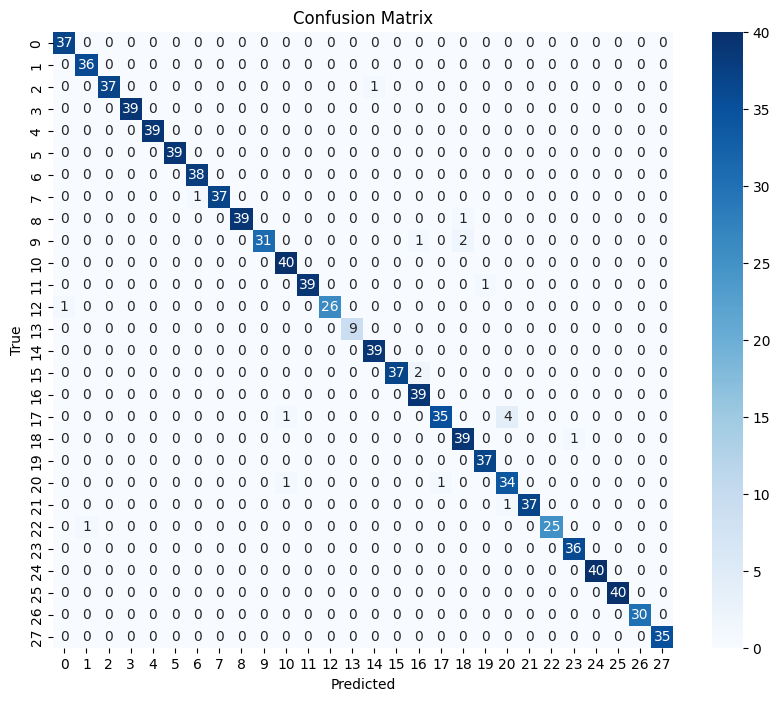

In [27]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Neural Network

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return F.softmax(x, dim=1)
    
model = MLP(input_dim=data.shape[1], hidden_dim=512, output_dim=len(np.unique(labels)))
print(model)


MLP(
  (fc1): Linear(in_features=42, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=28, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
loss = nn.CrossEntropyLoss()

for epoch in range(2000):
    model.train()
    optimizer.zero_grad()
    output = model(torch.from_numpy(x_train).float())
    loss_value = loss(output, torch.from_numpy(y_train).long())
    loss_value.backward()
    optimizer.step()

    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Loss: {loss_value.item()}')
        
model.eval()
y_pred = model(torch.from_numpy(x_test).float()).detach().numpy()
y_pred = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

Epoch 0, Loss: 3.332216501235962
Epoch 200, Loss: 2.7938356399536133
Epoch 400, Loss: 2.662187099456787
Epoch 600, Loss: 2.648531913757324
Epoch 800, Loss: 2.6105949878692627
Epoch 1000, Loss: 2.6075165271759033
Epoch 1200, Loss: 2.606447458267212
Epoch 1400, Loss: 2.606074094772339
Epoch 1600, Loss: 2.6055991649627686
Epoch 1800, Loss: 2.604985475540161
Accuracy: 0.7879088206144698
Precision: 0.6481618222758265
Recall: 0.7879088206144698
F1 Score: 0.7045543592913422


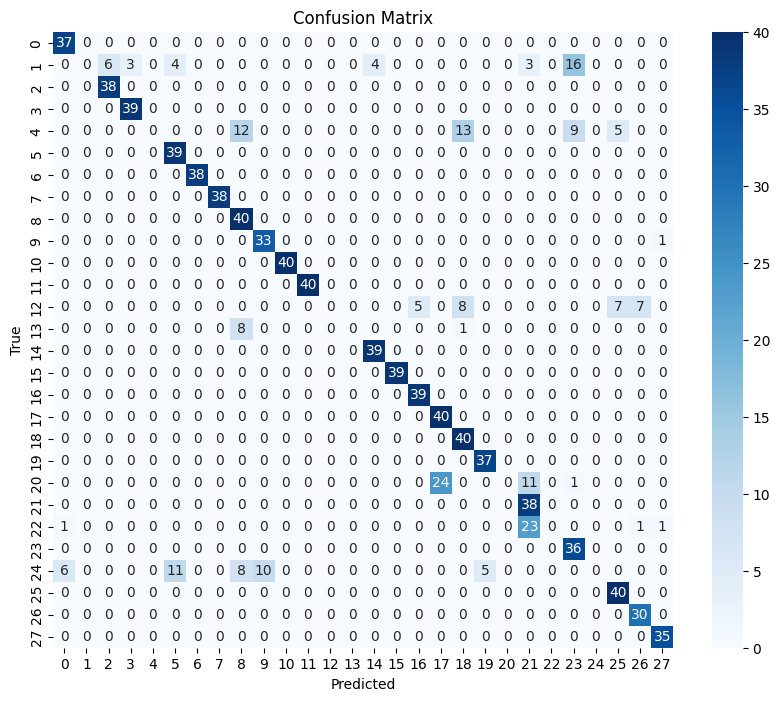

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Save the model
f = open('mlp_baseline.pkl', 'wb')
pickle.dump({'model': model}, f)
f.close()